In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import pandas as pd
import os
import json
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from bag_of_words import Clustering
from IPython.display import display
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
# Conferences
conf = ['acl_2017', 'arxiv.cs.ai_2007-2017', 'arxiv.cs.cl_2007-2017', 'arxiv.cs.lg_2007-2017', 'conll_2016', 'iclr_2017']

# JSON files to be parsed
dir_path    = '/Users/shashi/code/ML/CS-7641-ML-Project/data/'
train_path  = '/train/reviews/'
test_path   = '/test/reviews/'

In [3]:
tf_idf = Clustering()

# json_train_files = sorted([pos_json for pos_json in os.listdir(acl_train_path) if pos_json.endswith('.json')])
# json_test_files = sorted([pos_json for pos_json in os.listdir(acl_test_path) if pos_json.endswith('.json')])
json_train_files    = []
json_test_files     = []
N_training          = 0
N_testing           = 0
for c in conf:
    c_train_path    = dir_path + c + train_path
    c_test_path     = dir_path + c + test_path
    c_json_train    = sorted([pos_json for pos_json in os.listdir(c_train_path) if pos_json.endswith('.json')])
    c_json_test     = sorted([pos_json for pos_json in os.listdir(c_test_path) if pos_json.endswith('.json')])
    c_json_train    = [c_train_path + s for s in c_json_train]
    c_json_test     = [c_test_path + s for s in c_json_test]
    json_train_files.append(c_json_train)
    json_test_files.append(c_json_test)
    N_training += len(c_json_train)
    N_testing += len(c_json_test)

In [4]:
# Creating the dataset in string format
train_data  = []
test_data   = []
train_title = []
test_title  = []

for c in json_train_files:
    title, data = tf_idf.parse_json_files(c)
    train_data.extend(data)
    train_title.extend(title)

for c in json_test_files:
    title, data = tf_idf.parse_json_files(c)
    test_data.extend(data)
    test_title.extend(title)

merged_data = []
merged_data.extend(train_data)
merged_data.extend(test_data)

In [15]:
# Getting bag of words data structure
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
Count_data = CountVec.fit_transform(merged_data)
# print(CountVec.get_feature_names())
cv_dataframe=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names_out())
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
display(cv_dataframe.head(5).loc[:,cv_dataframe.head(5).any()])
# print(cv_dataframe)

,2014,abstraction,accuracy,achieve,achieves,addition,additionally,alignment,ambiguity,amounts,...,used,uses,using,usually,utilizing,various,weakly,webqsp,word,words
0,0,0,0,1,0,1,0,0,2,0,...,0,0,1,1,0,1,0,0,1,1
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,3,0,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,0,1,1,1,1,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [6]:
# Training the Model
# Getting tf-idf data structure
# Vectorize the text
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(merged_data)
X_train = X[0:len(train_data)]
X_test = X[len(train_data):]
tf_idf_df=pd.DataFrame(X_train.toarray(),columns=vectorizer.get_feature_names_out())
display(tf_idf_df.head(5).loc[:,tf_idf_df.head(5).any()])

KMeans(max_iter=1000, n_clusters=6)

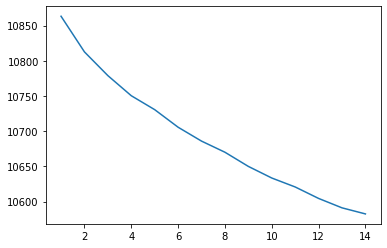

In [7]:
# cluster documents
distortions = []
K = range(1,15)

for k in K:
    model = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10)
    model.fit(X_train)
    distortions.append(model.inertia_)

plt.plot(K, distortions)
# print(distortions)

# Choosing the best k from elbow method.
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=10)
model.fit(X_train)

In [8]:
# Print top terms per cluster
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 model
 based
 language
 information
 knowledge
 systems
 paper
 approach
 using
 logic
Cluster 1:
 neural
 networks
 deep
 network
 learning
 convolutional
 model
 training
 models
 recurrent
Cluster 2:
 word
 embeddings
 semantic
 words
 representations
 language
 model
 models
 sentence
 embedding
Cluster 3:
 translation
 machine
 nmt
 neural
 english
 phrase
 source
 language
 model
 based
Cluster 4:
 algorithm
 learning
 algorithms
 problem
 optimization
 problems
 policy
 optimal
 stochastic
 search
Cluster 5:
 data
 learning
 classification
 clustering
 feature
 method
 algorithm
 based
 methods
 features


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
# Testing the Model
# Predict the cluster association of each paper
prediction = model.predict(X_test)
print(X_train.shape)
print(X_test.shape)
df = pd.DataFrame(list(zip(test_title, prediction)), columns =['Title', 'Cluster ID'])
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
display(df)
# display(df.loc[df['Cluster ID'] == 1])

(11090, 29445)
(637, 29445)


,Title,Cluster ID
0,Evaluation Metrics for Machine Reading Comprehension: Prerequisite Skills and Readability,0
1,A Neural Local Coherence Model,1
2,Neural Modeling of Multi-Predicate Interactions for Japanese Predicate Argument Structure Analysis,2
3,Neural Disambiguation of Causal Lexical Markers based on Context,0
4,Chunk-based Decoder for Neural Machine Translation,3
5,What do Neural Machine Translation Models Learn about Morphology?,3
6,Detecting Lexical Entailment in Context,2
7,Support Vector Machine Classification with Indefinite Kernels,5
8,The Parameterized Complexity of Global Constraints,4
9,Examples as Interaction: On Humans Teaching a Computer to Play a Game,0
